# Probability of guarantee (PG) model development

In the first step, **model development sample** will be downloaded from the analytical database table `playground.guarantee_model_dev_sample_airports_final_dsc`. This sample has been filtered from the overall development sample using the four below conditions. The fourth condition `is_direct = False` is equivalent to booking-level condition `not (#flights = #sectors)` and is automatically met as a result of the first condition.
- `node_type in ('stopover', 'transfer')` 
- `event_type in ('None','Delay','Schedule change')`
- `flight_window < 60`
- `is_direct = False` 

The development sample covers two most frequent and jointly modelable reasons of guarantee events - **Delays** and **Schedule changes**  - which collectively account for around **75% of all guarantee cases (by count and cost amount)**. The third significant portion of guarantee events are **Cancellations, which contribute around 20%**. They will be modelled using separate sample, where the fourth condition will play a more important role due to inclusion of all node types, including `start`, `end` and `stay`.  HNSW, Annoy, SVD, Embeddings

In [0]:
import abc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sklearn.linear_model as lm
import sklearn.metrics as m
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import imblearn.over_sampling as os
import imblearn.under_sampling as us
import statsmodels.api as sm
import openpyxl

%matplotlib inline

from functions import classification_table, classification_statistics, plot_classification_table, train_test_statistics
from pypika import Table, Query
from sqlalchemy import create_engine
from datetime import date

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 15)

np.random.seed(1)

class SqlDatabaseSource(abc.ABC):
    def __init__(self, connection_string, table_name, schema):
        self.engine = create_engine(connection_string)
        self.TABLE_NAME = table_name
        self.SCHEMA = schema

    def get_data(self, columns=["*"], where_query=None, departure_from=None, departure_to=None, limit=None):
        # example of where_query: where_query=[{"key": "search_type", "value": "oneway", "type": "equal"}]
        if columns is None:
            columns = ["*"]
        my_table = Table(name=self.TABLE_NAME, schema=self.SCHEMA)
        query = Query.from_(my_table)
        for element in columns:
            query = query.select(element)

        # just for sure :-)
        if limit:
            query = query[:limit]

        # can be put into where query if not used regularly, see to be completed below
        if departure_from and departure_to:
            query = query.where(getattr(my_table, "departure_time_utc") < departure_to) \
                .where(getattr(my_table, "departure_time_utc") >= departure_from)

        if where_query:  # to be completed for all possibilities < <= > >= != ...
            for q in where_query:
                if q.get("type") == "equal":
                    query = query.where(getattr(my_table, q["key"]) == q["value"])

        # musim zjistit proc na select * to nevraci nazvy sloupcu
        if columns != ["*"]:
            return pd.DataFrame(  # muze vratit jakejkoliv data type
                [dict(zip(columns, row)) for row in self.engine.execute(str(query)).fetchall()]
            )
        else:
            return pd.DataFrame(
                self.engine.execute(str(query)).fetchall()
            )


# je spustitelna verze pro kontrolu, vnitrek se da spustit napr v console
# if __name__ == "__main__":
task = SqlDatabaseSource(connection_string=os.getenv("kw_anal"),
                         table_name="guarantee_model_dev_sample_airports_final_dsc",
                         schema="playground")

data = task.get_data(columns=['bid', 'booking_date', 'departure_time_utc', 'trip_type', 'node', 'node_type', 'kiwi_guarantee', 'is_combination', 'stopover', 'mct', 'bags',
                              'mct_cushion', 'booking_window', 'flight_window', 'flight_mid_date', 'arr_src_country_id', 'dep_dst_country_id',
                              'oag_flights_prev', 'oag_cncl_pct_prev', 'oag_dep_otp_prev', 'oag_flights', 'oag_cncl_pct', 'oag_dep_otp',
                              'oag_arr_mk_flights', 'oag_arr_mk_cncl_pct', 'oag_arr_mk_arr_otp', 'oag_arr_op_flights', 'oag_arr_op_cncl_pct',
                              'oag_arr_op_arr_otp', 'oag_dep_mk_flights', 'oag_dep_mk_cncl_pct', 'oag_dep_mk_arr_otp', 'oag_dep_op_flights',
                              'oag_dep_op_cncl_pct', 'oag_dep_op_arr_otp', 'arr_departure_hour', 'dep_departure_hour', 'arr_airtime_hrs',
                              'dep_airtime_hrs', 'gr_prev', 'gr', 'absolute_margin', 'flg_guarantee', 'event_type', 'cost'])
    
df_raw = pd.DataFrame(data)
df_raw.head()

AttributeError: module 'imblearn.over_sampling' has no attribute 'getenv'

**Initialize development sample at node level** `df` and convert raw columns into correct dtypes.

In [0]:
df = df_raw.astype({'booking_date': 'datetime64', 'stopover': 'float', 'mct': 'float', 'bags': 'float', 'mct_cushion': 'float',
                    'booking_window': 'float', 'flight_window': 'float', 'flight_mid_date': 'datetime64', 'oag_cncl_pct_prev': 'float', 'oag_dep_otp_prev': 'float', 
                    'oag_cncl_pct': 'float', 'oag_dep_otp': 'float', 'oag_arr_mk_cncl_pct': 'float', 'oag_arr_mk_arr_otp': 'float', 'oag_arr_op_cncl_pct': 'float',
                    'oag_arr_op_arr_otp': 'float', 'oag_dep_mk_cncl_pct': 'float', 'oag_dep_mk_arr_otp': 'float', 'oag_dep_op_cncl_pct': 'float',
                    'oag_dep_op_arr_otp': 'float', 'arr_airtime_hrs': 'float', 'dep_airtime_hrs': 'float', 'gr': 'float', 'gr_prev': 'float',
                    'cost': 'float', 'absolute_margin': 'float', 'kiwi_guarantee': 'int64'})

df['flight_mid_month'] = df.flight_mid_date.dt.month
df['departure_month'] = df.departure_time_utc.dt.month
print('Development sample:\n', df.shape)
df.head()

Development sample:
 (1800856, 47)


,bid,booking_date,departure_time_utc,trip_type,node,node_type,kiwi_guarantee,...,gr,absolute_margin,flg_guarantee,event_type,cost,flight_mid_month,departure_month
0,26103297,2019-01-01,2019-01-03 23:10:00,oneway,[DEN],stopover,0,...,0.0059,51.94,0,None,0.0,1,1
1,26103297,2019-01-01,2019-01-04 11:00:00,oneway,[BOS],stopover,1,...,0.0143,51.94,0,None,0.0,1,1
2,26103352,2019-01-01,2019-03-18 21:30:00,oneway,[SFO],stopover,1,...,0.0041,147.15,0,None,0.0,3,3
3,26103352,2019-01-01,2019-03-19 07:50:00,oneway,[KEF],stopover,0,...,0.0050,147.15,0,None,0.0,3,3
4,26103352,2019-01-01,2019-03-19 11:40:00,oneway,[OSL],stopover,1,...,0.0043,147.15,0,None,0.0,3,3



**Select development sample at booking level** `df_bids` in order to plug it into random stratified splitting function `train_test_split()` using `flight_mid_month` as stratification parameter which will effectively allocate observations (bookings) into training and testing sample without generating duplicities.

In [0]:
# Select distinct bid, flight_mid_month  
df_bids = df[['bid', 'flight_mid_month']].drop_duplicates()
print('Development sample at booking level:', df_bids.shape)

Development sample at booking level: (1248924, 2)


**Partitioning of the development sample into training and testing samples** `df_train`, `df_test`, using **70%/30%** proportion. Two alternative methods were proposed. **The first algorithm ensures there are no booking-level duplicities** created due to allocation of nodes of one booking into both training and testing samples. The second generates a small number of duplicates (~1%), so it was currently not used (even though it's preferred by Roman Rožník).
- **Two-stage stratified random method** with stratification parameter `flight_mid_month`, defined as a month of `flight_mid_date`, which is in turn defined as a mid-point between booking's first `departure_date` and booking's `last_arrival_date`. For this method to work, bookings with `flight_window > 60` were excluded from the sample (~1% of observations and guarantees). The actual sample splitting is performed at booking level (using `df_bids`) and then each particular node will be assigned into respective sample based on train/test assignment of its booking.
- **Cut-off method** based on `departure_time_utc` of each node's departing flight. The actual sample splitting is performed at original node level. In this case, all nodes with `departure_time_utc` before `2019-07-23` will be assigned to training sample. 

In [0]:
# Two-stage stratified random, 70/30:

df_bids_train, df_bids_test = ms.train_test_split(df_bids, train_size=0.7, stratify=df_bids.flight_mid_month, random_state=100)
df_train = df[df.bid.isin(df_bids_train.bid)]
df_test = df[df.bid.isin(df_bids_test.bid)]

train_bid = df_train.bid.unique()
test_bid = df_test.bid.unique()
total_bid = df.bid.unique()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print('Two-stage stratified random - % of duplicities: ', round((len(train_bid)+len(test_bid))/len(total_bid)-1,1))
print('TRAIN:\t', len(df_train), '-', round(len(df_train)/len(df)*100), '%')
print('TEST:\t', len(df_test), '-', round(len(df_test)/len(df)*100), '%')
print('TOTAL:\t', len(df), '- 100 %\n')

# Cut-off by departure date, 70/30:

df['sample_id'] = df.apply(lambda x: 'TRAIN' if x['departure_time_utc'] <= pd.Timestamp(2019, 7, 23) else 'TEST', axis=1)
df_train_cut = df[df['sample_id'] == 'TRAIN']
df_test_cut = df[df['sample_id'] == 'TEST']

train_bid = df_train_cut.bid.unique()
test_bid = df_test_cut.bid.unique()
total_bid = df.bid.unique()

df_train_cut.reset_index(drop=True, inplace=True)
df_test_cut.reset_index(drop=True, inplace=True)

print('Cut-off by departure date - % of duplicities: ', round((len(train_bid)+len(test_bid))/len(total_bid)-1, 4))
print('TRAIN:\t', len(df_train_cut), '-', round(len(df_train_cut)/len(df)*100), '%')
print('TEST:\t', len(df_test_cut), '-', round(len(df_test_cut)/len(df)*100), '%')
print('TOTAL:\t', len(df), '- 100 %\n')

Two-stage stratified random - % of duplicities:  0.0
TRAIN:	 1260764 - 70 %
TEST:	 540092 - 30 %
TOTAL:	 1800856 - 100 %

Cut-off by flight_mid_date - % of duplicities:  0.0107
TRAIN:	 1248179 - 69 %
TEST:	 552677 - 31 %
TOTAL:	 1800856 - 100 %



**Sample partitioning statistics** - tables below show number of observations and guarantees for training and testing samples and also training sample proportions (of number of observations and guarantees) **by departure month** of node's departing flight. Results for both partitioning methods as described above are presented. It can be seen that the first method allocated observations proportionally for each month in the development sample, while the second method selected training and testing samples as disjoint sets, with cut-off flight departure date in July.

In [0]:
display(train_test_statistics(train_sample=df_train, test_sample=df_test, total_sample=df, response='flg_guarantee', groupby='departure_month'))
display(train_test_statistics(train_sample=df_train_cut, test_sample=df_test_cut, total_sample=df, response='flg_guarantee', groupby='departure_month'))

,departure_month,train_obs,test_obs,total_obs,train_obs (%),train_guar,test_guar,total_guar,train_guar (%)
0,1,55889,23963,79852,69.99,331,152,483,68.53
1,2,93170,39608,132778,70.17,526,211,737,71.37
2,3,124256,53543,177799,69.89,1002,426,1428,70.17
3,4,153600,65874,219474,69.99,1971,904,2875,68.56
4,5,164639,70483,235122,70.02,2314,960,3274,70.68
5,6,163683,70110,233793,70.01,2630,1101,3731,70.49
6,7,167207,71623,238830,70.01,2844,1267,4111,69.18
7,8,172726,73809,246535,70.06,2694,1153,3847,70.03
8,9,165594,71079,236673,69.97,2336,1000,3336,70.02
9,Total,1260764,540092,1800856,70.01,16648,7174,23822,69.88


,departure_month,train_obs,test_obs,total_obs,train_obs (%),train_guar,test_guar,total_guar,train_guar (%)
0,1,79852,0,79852,100.00,483,0,483,100.00
1,2,132778,0,132778,100.00,737,0,737,100.00
2,3,177799,0,177799,100.00,1428,0,1428,100.00
3,4,219474,0,219474,100.00,2875,0,2875,100.00
4,5,235122,0,235122,100.00,3274,0,3274,100.00
5,6,233793,0,233793,100.00,3731,0,3731,100.00
6,7,169361,69469,238830,70.91,2820,1291,4111,68.60
7,8,0,246535,246535,0.00,0,3847,3847,0.00
8,9,0,236673,236673,0.00,0,3336,3336,0.00
9,Total,1248179,552677,1800856,69.31,15348,8474,23822,64.43



**Define model predictors and binary response** and check missing values for each predictor separately for training and testing sample. Predictors related to marketing airlines of respective flights were excluded in this early stage due to their high pairwise correlations with operating airline predictors. Therefore in the further analyses, only predictors with `op` acronyms are used.
**Binary response variable** `flg_guarantee` is defined as `1` if either arriving or departing flight of the node incurred non-zero guarantee costs, otherwise it's defined as `0`. This definition of response variable makes the model interpretable as predicting only events with non-zero cash impact.

In [0]:
predictors = ['stopover', 'mct', 'gr', 'gr_prev', 'mct_cushion', 'booking_window', 'bags', 'absolute_margin', 'oag_flights_prev', 'oag_cncl_pct_prev',
              'oag_dep_otp_prev', 'oag_flights', 'oag_cncl_pct', 'oag_dep_otp',  # 'oag_arr_mk_flights', 'oag_arr_mk_cncl_pct', 'oag_arr_mk_arr_otp',
              'oag_arr_op_flights', 'oag_arr_op_cncl_pct', 'oag_arr_op_arr_otp',  # 'oag_dep_mk_flights', 'oag_dep_mk_cncl_pct', 'oag_dep_mk_arr_otp',
              'oag_dep_op_flights', 'oag_dep_op_cncl_pct', 'oag_dep_op_arr_otp', 'dep_airtime_hrs', 'arr_airtime_hrs', 'arr_departure_hour',
              'dep_departure_hour', 'kiwi_guarantee']

response = 'flg_guarantee'

print(pd.DataFrame({'TRAIN': df_train[predictors].isnull().sum(), 'TEST': df_test[predictors].isnull().sum()}))

                     TRAIN   TEST
stopover                 0      0
mct                      0      0
gr                       6      5
gr_prev                  5      2
mct_cushion              0      0
booking_window           0      0
bags                     0      0
absolute_margin          0      0
oag_flights_prev     94407  40410
oag_cncl_pct_prev    94407  40410
oag_dep_otp_prev     94407  40410
oag_flights          24747  10597
oag_cncl_pct         24747  10597
oag_dep_otp          24747  10597
oag_arr_op_flights   78963  33985
oag_arr_op_cncl_pct  78963  33985
oag_arr_op_arr_otp   78963  33985
oag_dep_op_flights   76895  33298
oag_dep_op_cncl_pct  76895  33298
oag_dep_op_arr_otp   76895  33298
dep_airtime_hrs          0      0
arr_airtime_hrs          0      0
arr_departure_hour       0      0
dep_departure_hour       0      0
kiwi_guarantee           0      0


**Impute missing values for each predictor** in `df_train` and `df_test` using respective predictor's **arithmetic mean**. We can see that the predictors with the most missing values in both samples have the missing proportion of around 7.5%. As this proportion is well **below the threshold of 10%**, none had to be excluded due to too many missing values. **For testing sample, the training sample means will be applied**, which is consistent with the model application in production.

In [0]:
for i in predictors:
    df_train[i].fillna(df_train[i].mean(), inplace=True)
    df_test[i].fillna(df_train[i].mean(), inplace=True)
                
print(pd.DataFrame({'TRAIN': df_train[predictors].isnull().sum(), 'TEST': df_test[predictors].isnull().sum()}))

                     TRAIN  TEST
stopover                 0     0
mct                      0     0
gr                       0     0
gr_prev                  0     0
mct_cushion              0     0
booking_window           0     0
bags                     0     0
absolute_margin          0     0
oag_flights_prev         0     0
oag_cncl_pct_prev        0     0
oag_dep_otp_prev         0     0
oag_flights              0     0
oag_cncl_pct             0     0
oag_dep_otp              0     0
oag_arr_op_flights       0     0
oag_arr_op_cncl_pct      0     0
oag_arr_op_arr_otp       0     0
oag_dep_op_flights       0     0
oag_dep_op_cncl_pct      0     0
oag_dep_op_arr_otp       0     0
dep_airtime_hrs          0     0
arr_airtime_hrs          0     0
arr_departure_hour       0     0
dep_departure_hour       0     0
kiwi_guarantee           0     0


**Univariate analysis - Spearman's correlations of each predictor with response** measuring predictor's ordinal association with response variable. We can see the most relevant variables in the top of the list. It is expected they will be also significant in the logistic regression model. Note that, with the exception of binary predictor `kiwi_guarantee`, all predictors are continuous.

In [0]:
spearman_r = []
for predictor in predictors:
    spearman_r.append(ss.spearmanr(df_train[predictor], df_train.flg_guarantee)[0])
    
spearman_r = pd.Series(spearman_r, index=predictors).abs().sort_values(ascending=False)
print("Univariate predictor Spearman correlation performance")
print(spearman_r)

Univariate predictor Spearman correlation performance
mct_cushion            0.063247
booking_window         0.059383
stopover               0.058416
gr                     0.048814
kiwi_guarantee         0.045871
absolute_margin        0.028401
dep_departure_hour     0.022903
gr_prev                0.019064
arr_departure_hour     0.018918
arr_airtime_hrs        0.017208
oag_dep_otp_prev       0.013961
bags                   0.013430
oag_flights_prev       0.012582
oag_arr_op_arr_otp     0.011479
oag_arr_op_flights     0.011344
oag_cncl_pct_prev      0.010058
oag_flights            0.008345
mct                    0.007040
oag_dep_op_cncl_pct    0.006737
oag_dep_otp            0.005518
oag_dep_op_flights     0.005196
oag_cncl_pct           0.003519
dep_airtime_hrs        0.003264
oag_arr_op_cncl_pct    0.001634
oag_dep_op_arr_otp     0.001183
dtype: float64


**Multivariate analysis - Correlation matrix of all predictors**. All absolute pairwise correlations are well **below 0.5** threshold, with one exception of `mct_cushion/stopover`. Because of this, `mct_cushion` **will be excluded from further analyses.**

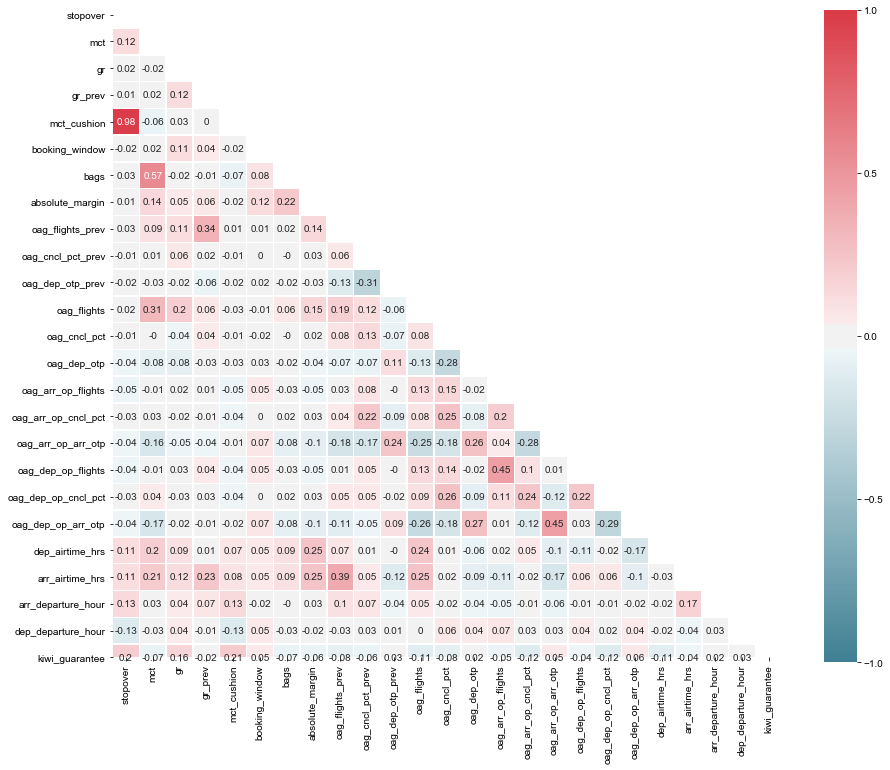

In [0]:
corr = df[predictors].corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8, 'ticks': [-1, -.5, 0, 0.5, 1]}, vmin=-1,
            vmax=1, annot=True, annot_kws={'size': 10})

ax.set_yticklabels(corr.columns, rotation=0)
ax.set_xticklabels(corr.columns, rotation=90)
sns.set(style="white")

**Define shortlist of predictors for model training** and narrow the training and testing samples `df_train` and `df_test` to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_test`, `y_train`, `y_test`.

In [0]:
shortlist = ['stopover', 'mct', 'gr', 'booking_window', 'bags', 'dep_departure_hour', 'dep_airtime_hrs', 'kiwi_guarantee']

X_train = df_train[shortlist]
y_train = df_train.flg_guarantee
X_test = df_test[shortlist]
y_test = df_test.flg_guarantee

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260764 entries, 0 to 1260763
Data columns (total 8 columns):
stopover              1260764 non-null float64
mct                   1260764 non-null float64
gr                    1260764 non-null float64
booking_window        1260764 non-null float64
bags                  1260764 non-null float64
dep_departure_hour    1260764 non-null float64
dep_airtime_hrs       1260764 non-null float64
kiwi_guarantee        1260764 non-null int64
dtypes: float64(7), int64(1)
memory usage: 77.0 MB


**Standardize shortlist of predictors** transforming each variable to `mean = 0` and `std = 1` using scikit-learn class `StandardScaler()`. Similarly as with missing values imputation, **standardization of testing sample** predictors `X_test` will be performed using `mean` and `scale` parameters calculated on **training sample**. For obvious reasons, standardization is performed **on continuous predictors only** - `kiwi_guarantee` predictor is therefore omitted.

In [0]:
std = pp.StandardScaler()
std.fit(X_train.drop('kiwi_guarantee', axis=1))

X_train = pd.concat([pd.DataFrame(std.transform(X_train.drop('kiwi_guarantee', axis=1)), columns=X_train.columns[:-1]), X_train.kiwi_guarantee], axis=1)
X_test = pd.concat([pd.DataFrame(std.transform(X_test.drop('kiwi_guarantee', axis=1)), columns=X_test.columns[:-1]), X_test.kiwi_guarantee], axis=1)

**Scikit-learn logistic regression** - initialise and fit the logistic regression model on training sample using shortlist of predictors. The model setup without regularization (`C=9999`) and with `newton-cg` optimisation method was selected to ensure **comparability of coefficient estimates of statsmodels `Logit()` and scikit-learn `LogisticRegression()` classes output**.

In [0]:
model = lm.LogisticRegression(solver='newton-cg', C=9999, random_state=1)
model.fit(X=X_train, y=y_train)

LogisticRegression(C=9999, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

**Coefficient estimates and the respective relative weights** of each predictor in the model. Note that weights are not calculated for `intercept` and binary variable `kiwi_guarantee`, for which the weight is not defined. Also notable are the **signs of the coefficient estimates**. For all coefficients, **statistical interpretation is in line with the business logic**. With the exception of the `stopover`, all signs are positive, which means only for `stopover` predictor holds that if its value increases, the probability of guarantee event decreases. For all other predictors, an increase in value of `mct`, `gr`, `booking_window`, `bags`, `dep_departure_hour`, `dep_airtime_hrs` or `kiwi_guarantee` (i.e. change from kiwi-unprotected node to kiwi-protected node) increases the probability of guarantee event with non-zero cash impact.

In [0]:
weights = pd.Series(np.round(100*abs(model.coef_[0])/np.absolute(model.coef_[0][:-1]).sum(),2), name='weight (%)', index=shortlist)
coefficient_estimates = pd.concat([pd.Series(np.append(model.intercept_, model.coef_[0]), index=['intercept'] + shortlist, name='coefficient estimate'), weights], axis=1, sort=False)
coefficient_estimates.loc[['intercept','kiwi_guarantee'], 'weight (%)']=0
coefficient_estimates

,coefficient estimate,weight (%)
intercept,-7.405685,0.00
stopover,-1.567234,59.70
mct,0.199929,7.62
gr,0.222954,8.49
booking_window,0.353397,13.46
bags,0.057463,2.19
dep_departure_hour,0.112454,4.28
dep_airtime_hrs,0.111895,4.26
kiwi_guarantee,2.704071,0.00


**Statsmodels logistic regression** - initialize and fit the logistic regression model on training sample, displaying full statistical output. All predictors are significant with `p-value well below 0.05`. The overall model performance metric `Pseudo R-squared = 0.1` indicates not that bad result, given that values between 0.2 and 0.4 are generally considered as a very good fit (http://cowles.yale.edu/sites/default/files/files/pub/d04/d0474.pdf).

In [0]:
logit_model = sm.Logit(y_train, pd.concat([pd.Series(np.ones(X_train.shape[0]), name='intercept'), X_train], axis=1))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.063167
         Iterations 11
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.101      
Dependent Variable:   flg_guarantee    AIC:              159295.3597
Date:                 2019-11-10 21:59 BIC:              159403.7848
No. Observations:     1260764          Log-Likelihood:   -79639.    
Df Model:             8                LL-Null:          -88577.    
Df Residuals:         1260755          LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       11.0000                                       
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
intercept          -7.4057   0.0557 -132.9861 0.0000 -7.5148 -7.2965
stopover           -1.5672 

**Scoring training and testing samples** by adding predicted event probabilities (`pg`) and then **aggregate the samples to booking level in order to evaluate model performance** using **net guarantee savings**. Lost opportunity amount (`absolute_margin`) is stored at booking level only, therefore we need to take single value (maximum) per booking. Guarantee costs (`cost`) will instead be summed as they are incurred on airport/flight level. Probablity of guarantee (`pg`) at booking level will be calculated as a sum of predicted probabilities at airport level. Actual responses (`flg_guarantee`) at booking level will be calculated as maximum of node-level responses. Predicted event responses (`prediction`) will be calculated using cut-off threshold applied to predicted event probabilities.

In [0]:
threshold = 0.22

pred_prob_train = pd.Series(model.predict_proba(X_train)[:, 1], name='pg')
pred_prob_test  = pd.Series(model.predict_proba(X_test)[:, 1], name='pg')

train_scored = pd.concat([df_train, pred_prob_train], axis=1)
test_scored = pd.concat([df_test, pred_prob_test], axis=1)

train_scored_bid = pd.concat([train_scored.groupby('bid').absolute_margin.agg(max), 
                              train_scored.groupby('bid').cost.agg(sum), 
                              train_scored.groupby('bid').pg.agg(sum), 
                              train_scored.groupby('bid').flg_guarantee.agg(max)], axis=1)

test_scored_bid  = pd.concat([test_scored.groupby('bid').absolute_margin.agg(max), 
                              test_scored.groupby('bid').cost.agg(sum), 
                              test_scored.groupby('bid').pg.agg(sum), 
                              test_scored.groupby('bid').flg_guarantee.agg(max)], axis=1)

train_scored_bid.reset_index(inplace=True)
test_scored_bid.reset_index(inplace=True)

prediction_train_bid = pd.Series(pp.binarize([train_scored_bid.pg], threshold)[0], name='prediction')
prediction_test_bid  = pd.Series(pp.binarize([test_scored_bid.pg],  threshold)[0], name='prediction')

train_scored_bid = pd.concat([train_scored_bid, prediction_train_bid], axis=1)
test_scored_bid = pd.concat([test_scored_bid, prediction_test_bid], axis=1)
total_scored_bid = pd.concat([train_scored_bid, test_scored_bid], axis=0)

print('SCORED TRAIN BID:', len(train_scored_bid), '-', int(np.ceil(len(train_scored_bid)/len(total_scored_bid)*100)), '%')
print('SCORED TEST BID: ', len(test_scored_bid), '-', int(np.floor(len(test_scored_bid)/len(total_scored_bid)*100)), '%')
print('SCORED TOTAL BID:', len(total_scored_bid), '- 100 %')

SCORED TRAIN BID: 874246 - 70 %
SCORED TEST BID:  374678 - 30 %
SCORED TOTAL BID: 1248924 - 100 %


**Evaluate model performance on training and testing samples at booking level**, using `AUROC`, `Somers'D`, `FP` and `TP` metrics. Finally, generate and display `classification table` and `classification_statistics`, using the selected cut-off `threshold` value `0.22`.

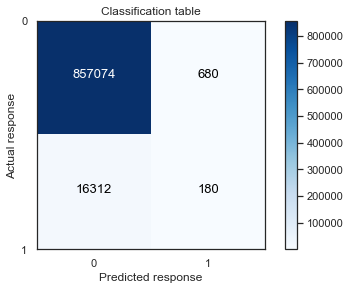

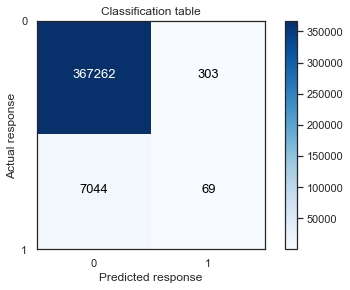

TRAIN Model performance results:
 Somers'D:	 0.5836 
 AUROC:		 0.7918 
 FP/TP:		 3.78 

TEST Model performance results:
 Somers'D:	 0.5716 
 AUROC:		 0.7858 
 FP/TP:		 4.39 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    857754
           1       0.21      0.01      0.02     16492

    accuracy                           0.98    874246
   macro avg       0.60      0.51      0.51    874246
weighted avg       0.97      0.98      0.97    874246

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    367565
           1       0.19      0.01      0.02      7113

    accuracy                           0.98    374678
   macro avg       0.58      0.50      0.50    374678
weighted avg       0.97      0.98      0.97    374678



In [0]:
# Metrics
auroc_train = round(m.roc_auc_score(train_scored_bid.flg_guarantee, train_scored_bid.pg), 4)
auroc_test = round(m.roc_auc_score(test_scored_bid.flg_guarantee, test_scored_bid.pg), 4)
somers_d_train = round(2*auroc_train-1, 4)
somers_d_test = round(2*auroc_test-1, 4)

# Classification table
ct_train = classification_table(actual_response=train_scored_bid.flg_guarantee, predicted_prob=train_scored_bid.pg, threshold=threshold)
ct_test  = classification_table(actual_response=test_scored_bid.flg_guarantee,  predicted_prob=test_scored_bid.pg,  threshold=threshold)
plot_classification_table(ct_train, [0, 1], title='Classification table', cmap=plt.cm.Blues)
plot_classification_table(ct_test,  [0, 1], title='Classification table', cmap=plt.cm.Blues)

# Print results
print('TRAIN Model performance results:\n Somers\'D:\t', somers_d_train, '\n', "AUROC:\t\t", auroc_train, '\n', 'FP/TP:\t\t', np.round(ct_train[0][1]/ct_train[1][1], 2), '\n')
print('TEST Model performance results:\n Somers\'D:\t', somers_d_test, '\n', "AUROC:\t\t", auroc_test, '\n', 'FP/TP:\t\t', np.round(ct_test[0][1]/ct_test[1][1], 2), '\n')
print(classification_statistics(actual_response=train_scored_bid.flg_guarantee, predicted_prob=train_scored_bid.pg, threshold=threshold))
print(classification_statistics(actual_response=test_scored_bid.flg_guarantee,  predicted_prob=test_scored_bid.pg,  threshold=threshold))

Check the model performance by calculating the amount of **net guarantee savings** as difference of **saved guarantee costs** incurred on true positives (actual guarantees predicted as guarantee) and **lost opportunity** on false positives (actual non-guarantees predicted as guarantee): 
`cost(TP) - absolute_margin(FP)`.

In [0]:
train_scored_bid_tp = train_scored_bid[(train_scored_bid.pg > threshold) & (train_scored_bid.flg_guarantee == 1)]
train_scored_bid_fp = train_scored_bid[(train_scored_bid.pg > threshold) & (train_scored_bid.flg_guarantee == 0)]
test_scored_bid_tp = test_scored_bid[(test_scored_bid.pg > threshold) & (test_scored_bid.flg_guarantee == 1)]
test_scored_bid_fp = test_scored_bid[(test_scored_bid.pg > threshold) & (test_scored_bid.flg_guarantee == 0)]

print('TRAIN Saved guarantee costs:', round(train_scored_bid_tp.cost.sum(), 2))
print('TRAIN Lost margin opportunity:', round(train_scored_bid_fp.absolute_margin.sum(), 2))
print('TRAIN NET Guarantee savings:', round(train_scored_bid_tp.cost.sum() - train_scored_bid_fp.absolute_margin.sum(),2), '\n')
print('TEST Saved guarantee costs:', round(test_scored_bid_tp.cost.sum(), 2))
print('TEST Lost margin opportunity:', round(test_scored_bid_fp.absolute_margin.sum(), 2))
print('TEST NET Guarantee savings:', round(test_scored_bid_tp.cost.sum() - test_scored_bid_fp.absolute_margin.sum(),2))

TRAIN Saved guarantee costs: 110955.5
TRAIN Lost margin opportunity: 90291.22
TRAIN NET Guarantee savings: 20664.28 

TEST Saved guarantee costs: 44736.16
TEST Lost margin opportunity: 39617.88
TEST NET Guarantee savings: 5118.28


**Check the model classification performance** based on varying cut-off threshold, between `0.02` and `0.5`.

In [0]:
def model_performance(threshold=0.5):
    pred_prob_train = pd.Series(model.predict_proba(X_train)[:, 1], name='pg')
    pred_prob_test  = pd.Series(model.predict_proba(X_test)[:, 1], name='pg')

    train_scored = pd.concat([df_train, pred_prob_train], axis=1)
    test_scored = pd.concat([df_test, pred_prob_test], axis=1)

    train_scored_bid = pd.concat([train_scored.groupby('bid').absolute_margin.agg(max), 
                                  train_scored.groupby('bid').cost.agg(sum), 
                                  train_scored.groupby('bid').pg.agg(sum), 
                                  train_scored.groupby('bid').flg_guarantee.agg(max)], axis=1)

    test_scored_bid  = pd.concat([test_scored.groupby('bid').absolute_margin.agg(max), 
                                  test_scored.groupby('bid').cost.agg(sum), 
                                  test_scored.groupby('bid').pg.agg(sum), 
                                  test_scored.groupby('bid').flg_guarantee.agg(max)], axis=1)

    train_scored_bid.reset_index(inplace=True)
    test_scored_bid.reset_index(inplace=True)

    prediction_train_bid = pd.Series(pp.binarize([train_scored_bid.pg], threshold)[0], name='prediction')
    prediction_test_bid  = pd.Series(pp.binarize([test_scored_bid.pg],  threshold)[0], name='prediction')

    train_scored_bid = pd.concat([train_scored_bid, prediction_train_bid], axis=1)
    test_scored_bid = pd.concat([test_scored_bid, prediction_test_bid], axis=1)
    total_scored_bid = pd.concat([train_scored_bid, test_scored_bid], axis=0)

    auroc_train = round(m.roc_auc_score(train_scored_bid.flg_guarantee, train_scored_bid.pg), 4)
    auroc_test = round(m.roc_auc_score(test_scored_bid.flg_guarantee, test_scored_bid.pg), 4)
    somers_d_train = round(2*auroc_train-1, 4)
    somers_d_test = round(2*auroc_test-1, 4)

    ct_train = classification_table(actual_response=train_scored_bid.flg_guarantee, predicted_prob=train_scored_bid.pg, threshold=threshold)
    ct_test  = classification_table(actual_response=test_scored_bid.flg_guarantee,  predicted_prob=test_scored_bid.pg,  threshold=threshold)

    train_scored_bid_tp = train_scored_bid[(train_scored_bid.pg > threshold) & (train_scored_bid.flg_guarantee == 1)]
    train_scored_bid_fp = train_scored_bid[(train_scored_bid.pg > threshold) & (train_scored_bid.flg_guarantee == 0)]
    test_scored_bid_tp = test_scored_bid[(test_scored_bid.pg > threshold) & (test_scored_bid.flg_guarantee == 1)]
    test_scored_bid_fp = test_scored_bid[(test_scored_bid.pg > threshold) & (test_scored_bid.flg_guarantee == 0)]

    results_by_sample = pd.DataFrame({'threshold': [threshold, threshold], 'sample_id': ['TRAIN', 'TEST'], 'tp': [ct_train[1][1], ct_test[1][1]], 'fp': [ct_train[0][1], ct_test[0][1]], 'tn': [ct_train[0][0], ct_test[0][0]], 'fn': [ct_train[1][0], ct_test[1][0]], 
                                      'fp/tp': [round(ct_train[0][1]/ct_train[1][1],2), round(ct_test[0][1]/ct_test[1][1],2)] , 'auroc': [auroc_train, auroc_test], 'somers_d': [somers_d_train, somers_d_test],
                                      'saved_cost': [round(train_scored_bid_tp.cost.sum(), 2), round(test_scored_bid_tp.cost.sum(), 2)], 'lost_margin': [round(train_scored_bid_fp.absolute_margin.sum(), 2), round(test_scored_bid_fp.absolute_margin.sum(), 2)],
                                      'net_savings': [round(train_scored_bid_tp.cost.sum() - train_scored_bid_fp.absolute_margin.sum(),2), round(test_scored_bid_tp.cost.sum() - test_scored_bid_fp.absolute_margin.sum(),2)]})
    
    results = pd.DataFrame({'threshold': threshold, 'sample_id': 'TOTAL', 'tp': results_by_sample.tp.sum(), 'fp': results_by_sample.fp.sum(), 'fp/tp (train)': results_by_sample.loc[0,'fp/tp'],  
                            'fp/tp (test)': results_by_sample.loc[1,'fp/tp'], 'auroc': results_by_sample.auroc.mean(), 'somers_d': results_by_sample.somers_d.mean(), 
                            'saved_cost': results_by_sample.saved_cost.sum(), 'lost_margin': results_by_sample.lost_margin.sum(),
                            'net_savings': results_by_sample.net_savings.sum()}, index=[0])
    
    return results, results_by_sample
    

def model_performance_thresholds(thresholds):
    for i, threshold in enumerate(thresholds):
        results, results_by_sample = model_performance(threshold)
        if i == 0:
            results_threshold = results
            results_by_sample_threshold = results_by_sample
        else:
            results_threshold = pd.concat([results_threshold, results], axis=0)
            results_by_sample_threshold = pd.concat([results_by_sample_threshold, results_by_sample], axis=0)
            
    return results_threshold, results_by_sample_threshold
        
#results, results_by_sample = model_performance(threshold=0.22)
results_threshold, results_by_sample_threshold = model_performance_thresholds(thresholds=np.linspace(0.02, 0.5, num=25))
results_threshold

,threshold,sample_id,tp,fp,fp/tp (train),fp/tp (test),auroc,somers_d,saved_cost,lost_margin,net_savings
0,0.02,TOTAL,18073,404917,22.33,22.57,0.7888,0.5776,7686466.35,30557588.21,-22871121.86
0,0.04,TOTAL,9407,122319,12.98,13.05,0.7888,0.5776,4603449.68,11544385.44,-6940935.76
0,0.06,TOTAL,4934,48057,9.65,9.96,0.7888,0.5776,2656563.12,5190414.07,-2533850.95
0,0.08,TOTAL,2854,22551,7.82,8.09,0.7888,0.5776,1655051.32,2676677.66,-1021626.34
0,0.10,TOTAL,1737,11864,6.72,7.11,0.7888,0.5776,1047940.40,1511792.88,-463852.48
0,0.12,TOTAL,1145,6751,5.81,6.11,0.7888,0.5776,714564.42,894069.34,-179504.92
0,0.14,TOTAL,791,4137,5.08,5.63,0.7888,0.5776,509793.38,567312.40,-57519.02
0,0.16,TOTAL,567,2691,4.58,5.18,0.7888,0.5776,367598.88,381781.77,-14182.89
0,0.18,TOTAL,412,1833,4.21,5.10,0.7888,0.5776,269314.08,259048.64,10265.44
0,0.20,TOTAL,309,1337,4.13,4.83,0.7888,0.5776,197012.69,179967.74,17044.95


**SMOTE over-sampling method** used as an attempt to improve classifier's prediction accuracy after which scikit-learn logistic regression model is re-fitted.

In [0]:
from imblearn.over_sampling import SMOTE
    
smote = os.SMOTE(sampling_strategy=0.06, k_neighbors=5)
os_X_train, os_y_train = smote.fit_sample(X_train, y_train)

os_model = lm.LogisticRegression(solver='newton-cg', C=9999, random_state=1)
os_model.fit(X=os_X_train, y=os_y_train)

print('Coefficient estimates:')
print(pd.Series(np.append(os_model.intercept_, os_model.coef_[0]), index=['intercept'] + shortlist))

For both the **training** and **testing** samples, calculate **predicted event probabilities** `y_pred_prob` and **predicted event responses** `y_pred` from the estimated model and **evaluate the model performance** using `AUROC`, `Somers'D`, `FP` and `TP` metrics. Finally, generate and display `classification table` and `classification_statistics`, using cut-off `threshold` equal to `0.2`.

In [0]:
threshold = 0.2

# Predictions
y_pred_prob_train = os_model.predict_proba(os_X_train)[:, 1]
y_pred_prob_test  = os_model.predict_proba(X_test)[:, 1]
y_pred_train = pp.binarize([y_pred_prob_train], threshold)[0]
y_pred_test  = pp.binarize([y_pred_prob_test],  threshold)[0]
predictions_train = pd.DataFrame(data={'pg': y_pred_prob_train, 'prediction': y_pred_train})
predictions_test  = pd.DataFrame(data={'pg': y_pred_prob_test,  'prediction': y_pred_test})

# Metrics
auroc_train = round(m.roc_auc_score(os_y_train, y_pred_prob_train), 4)
auroc_test = round(m.roc_auc_score(y_test, y_pred_prob_test), 4)
somers_d_train = round(2*auroc_train-1, 4)
somers_d_test = round(2*auroc_test-1, 4)

# Classification table
ct_train = classification_table(actual_response=os_y_train, predicted_prob=y_pred_prob_train, threshold=threshold)
ct_test  = classification_table(actual_response=y_test,  predicted_prob=y_pred_prob_test,  threshold=threshold)
plot_classification_table(ct_train, [0, 1], title='Classification table', cmap=plt.cm.Blues)
plot_classification_table(ct_test,  [0, 1], title='Classification table', cmap=plt.cm.Blues)

# Print results
print('TRAIN Model performance results:\n Somers\'D:\t', somers_d_train, '\n', "AUROC:\t\t", auroc_train, '\n', 'FP/TP:\t\t', np.round(ct_train[0][1]/ct_train[1][1], 2), '\n')
print('TEST  Model performance results:\n Somers\'D:\t', somers_d_test, '\n', "AUROC:\t\t", auroc_test, '\n', 'FP/TP:\t\t', np.round(ct_test[0][1]/ct_test[1][1], 2), '\n')
print(classification_statistics(actual_response=os_y_train, predicted_prob=y_pred_prob_train, threshold=threshold))
print(classification_statistics(actual_response=y_test,  predicted_prob=y_pred_prob_test,  threshold=threshold))